## Preliminaries

In [1]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

import gurobipy as gp
from gurobipy import GRB

In [2]:
'''Return Euclidean distance from a to b'''
def dist(a, b):
#     return math.sqrt(sum([(i-j)**2 for i,j in zip(a,b)]))
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

'''Return closest facility to p from set opens.
   return -1 if opens is empty
'''
def find_closest_f(opens, p):
    if not opens: # No facility has opened yet
        return (-1,0)
    dists = list(map(lambda x: dist(x,p), opens))
    idx = np.argmin(dists)
    return (idx, dists[idx])

In [3]:
'''
Generates uniform random points on the grid
'''
def uniform_random_points(n, MIN=1, MAX=20):
    points = []
    for _ in range(n):
        x, y = np.random.randint(MIN, MAX), np.random.randint(MIN, MAX)
        points.append((x,y))
    return points

## Solvers (Optimal, Meyerson, PredFL)

### Optimal

In [4]:
from itertools import product

def LPG(customers, facilities, f, savefile=None):
    num_customers = len(customers)
    num_facilities = len(facilities)
    cartesian_prod = list(product(range(num_customers), range(num_facilities)))

    # Compute cost
    setup_cost = [f] * num_facilities
    shipping_cost = {(c,f): dist(customers[c], facilities[f]) for c, f in cartesian_prod}
    
#     print("Initialize Model")
    
    m = gp.Model('facility_location')
    m.Params.LogToConsole = 0
    m.Params.Method = 1

    select = m.addVars(num_facilities, lb=0, vtype=GRB.CONTINUOUS, name='Select')
    assign = m.addVars(cartesian_prod, lb=0, vtype=GRB.CONTINUOUS, name='Assign')

    m.addConstrs((assign[(c,f)] <= select[f] for c,f in cartesian_prod), name='Setup2ship')
    m.addConstrs((gp.quicksum(assign[(c,f)] for f in range(num_facilities)) == 1 for c in range(num_customers)), name='Demand')

    m.setObjective(select.prod(setup_cost)+assign.prod(shipping_cost), GRB.MINIMIZE)
    
#     print("Optimize Model")

    m.optimize()
    
    if savefile:
        m.write("{0}.sol".format(savefile))
    
    # Retrieve Solution 
    
    n = num_customers
    M = num_facilities
    
    c = np.array(
        [
            [dist(facilities[i], customers[j]) for j in range(n)]
            for i in range(M)
        ]
    )
    
    ret_x = np.array([ select[i].x for i in range(M)])
    # y[i,j] facility i connects with demand j
    ret_y = np.array(
        [
            [assign[(j,i)].x for j in range(n)]
            for i in range(M)
        ]
    )

    return ret_x, ret_y, c

#### Rounding

In [5]:
def primal_rounding(x, y, c):
    # x: 1*n, y: n*n
    n = x.size
    #### ----- filtering ------- ######
    c_bar = np.array([ c[:,j] @ y[:,j] for j in range(n)])
    
    # S_j sets
    S = []
    S_l = []
    # for each demand j: Sj = facilities where c[i,j] < 2c_bar[j]
    for j in range(n):
        cand = []
        for i in range(n):
            if c[i,j] <= c_bar[j]: cand.append(i)
        S.append(set(cand))
        S_l.append(cand)
    
    y_bar = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i in S[j]:
                # maybe change that later
                y_bar[i,j] = y[i,j] / np.sum([y[i,j] for i in S_l[j]])
                
    x_bar = np.minimum(2 * x, 1)
            
    #### ----- rounding ------- ######
    xx = np.zeros(n)
    yy = np.zeros((n,n))
    
    unassigned = np.array([True] * n)
    cnt = 0
    while(cnt < n):
        # find min unassigned
        c_min = np.inf
        c_idx = 0
        for j in range(n):
            if unassigned[j] and (c_bar[j] < c_min):
                c_min = c_bar[j]
                c_idx = j
        
        unassigned[c_idx] = False
        f_idx = S_l[c_idx][0]
        
        # open facility
        xx[f_idx] = 1
        
        # assign demand to facility
        yy[f_idx, c_idx] = 1
        cnt += 1
        
        for j in range(n):
            if (j != c_idx) and (unassigned[j]):
                if (S[c_idx].intersection(S[j])):
                    unassigned[j] = False
                    
                    yy[f_idx, j] = 1
                    cnt += 1
    return xx,yy

In [6]:
# use lpg2 for now

def Optimal(demands, facilities, f, savefile=None):
    n = len(demands)
    M = len(facilities)
    
    lx, ly, c = LPG(demands, facilities, f, savefile)
    x, y = primal_rounding(lx, ly, c)
    
    cost = 0
    ret_facilities = []
    for i in range(n):
        if x[i]:
            ret_facilities.append(demands[i])
    cost += f * len(ret_facilities)
    
    assignments = []
    for j in range(n):
        for i in range(M):
            if y[i,j]:
                assignments.append((demands[j], facilities[i]))
                cost += c[i,j]
                
                break
    return cost, facilities, assignments

### Meyerson @ PredFl

In [7]:
'''
Run Meyerson's randomized algorithm on data, with facility cost f
return: (set of open facilities, pairs of (facilities,points assigned to facs) and total cost of solution
'''
from collections import defaultdict
debug = False

def Meyerson(points, f):
    global debug
    open_facs = []
    cost = 0
    
#     assg = defaultdict(list) # Contains tuples of the form (open fac, point connected to fac)
    assg = [] # Contains tuples of the form (open fac, point connected to fac)
    
    if(debug): print(points)
    
    for p in points:
        if(debug): print("Point : ", p)
        fopen, delta = find_closest_f(open_facs, p)
        if(debug): print("Closest facility :", fopen)
        if(fopen == -1):
            delta = f
        else:
            delta = min(f, delta)
            
        if(np.random.binomial(1, delta/f) == 1):# coin toss succeeds
            open_facs.append(p)
            cost += f
            assg.append((p, p))
        else: # Facility did not open, connect instead
            cost += delta
            assg.append((p, open_facs[fopen]))
            
    return (cost, open_facs, assg)

In [8]:
'''
Learning Augmented Meyerson
data: list(point, prediction)
'''

def PredFL(points, preds, f):
    open_facs = []
    cost = 0
#     assg = defaultdict(list) # Contains tuples of the form (open fac, point connected to fac)
    assg = []
    
    for p, pred in zip(points,preds):
        fopen, _ = find_closest_f(open_facs, p)
        if(fopen == -1):
            delta = f
        else:
            delta = min(f, dist(pred, open_facs[fopen]))
        
        if(np.random.binomial(1, delta/f) == 1):# coin toss succeeds
            open_facs.append(pred)
            cost += f + dist(p, pred)
            assg.append((p, pred))
        else: # Facility did not open, connect instead
            opfac = open_facs[fopen]
            cost += dist(p, opfac)
            assg.append((p, opfac))
            
    return (cost, open_facs, assg)

## Utilities

### Plot solution

In [360]:
def plot_solution(assignments, title=None, figsize=None):
    if figsize:
        plt.subplots(figsize=figsize)
    for d,c in assignments:
#         print(d,c)
        plt.plot([d[0],c[0]], [d[1],c[1]], '-o')
    if title:
        plt.title(title)
    
#     plt.show()

### Predictions

In [124]:
def alpha_near(p, c, alpha):
    if (p == c) or (alpha == 0):
        return c

    p_x, p_y = p
    c_x, c_y = c
    
    if (p_x == c_x):
        # Avoid division by zero
        return (c_x, c_y + (p_y-c_y) * alpha)
    
    slope = (p_y - c_y)/(p_x - c_x)
    d = dist(p,c)
    if(p_x < c_x):
        alpha_x = c_x - (alpha * d / math.sqrt(slope ** 2 + 1))
    else:
        alpha_x = c_x + (alpha * d / math.sqrt(slope ** 2 + 1))
    
    alpha_y = c_y + slope * (alpha_x - c_x)
    
    return (alpha_x, alpha_y)

In [230]:
def alpha_predictor(assignments, alpha):
    preds = []
    for p, c in assignments:
        preds.append(alpha_near(p, c, alpha))
    return preds

In [144]:
def alpha_gaussian_predictor(assignments, alpha, std):
    preds = []
    for p, c in assignments:
        g_alpha = np.random.normal(alpha, std)
        
        g_alpha = np.absolute(g_alpha)
        
        pred = alpha_near(p, c, g_alpha)
        preds.append(pred)
    return preds

In [126]:
def alpha_gaussian_predictor_truncated(assignments, alpha, std):
    preds = []
    for p, c in assignments:
        g_alpha = np.random.normal(alpha, std)
        
        g_alpha = min(g_alpha,1)
        g_alpha = max(g_alpha,0)
            
        preds.append(alpha_near(p, c, g_alpha))
    return preds

In [332]:
def choice():
    if np.random.rand() > 0.5:
        return 1
    else:
        return -1

def random_alpha_near(p, c, alpha):
    if (p == c) or (alpha == 0):
        return c

    p_x, p_y = p
    c_x, c_y = c
    
    if (p_x == c_x):
        # Avoid division by zero
        return (c_x, c_y + (p_y-c_y) * alpha * choice())
    
    slope = (p_y - c_y)/(p_x - c_x)
    d = dist(p,c)
    if(p_x < c_x):
        alpha_x = c_x - (alpha * d / math.sqrt(slope ** 2 + 1)) * choice()
    else:
        alpha_x = c_x + (alpha * d / math.sqrt(slope ** 2 + 1)) * choice()
    
    alpha_y = c_y + slope * (alpha_x - c_x) * choice()
    
    return (alpha_x, alpha_y)

def random_alpha_predictor(assignments, alpha):
    preds = []
    for p, c in assignments:
        preds.append(random_alpha_near(p, c, alpha))
    return preds

## Pre-Experiments

### Optimal Solution

In [11]:
n = 100
MIN = 0
MAX = 1000

f = 500

points = uniform_random_points(n, MIN, MAX)

Academic license - for non-commercial use only - expires 2021-07-16
Using license file /home/jupyter/gurobi.lic
CPU times: user 351 ms, sys: 5.06 ms, total: 356 ms
Wall time: 357 ms


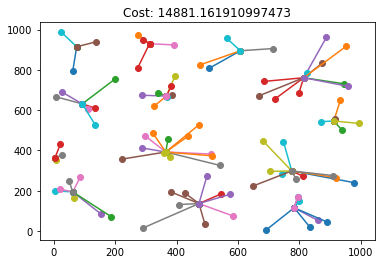

In [12]:
%%time
opt_cost, opt_facs, opt_assgn = Optimal(points, points, f)
plot_solution(opt_assgn, r'Cost: ' + str(opt_cost))

## Randomly generated data

In [239]:
def run_experiments(points, f, optimal_solution, predictor, predictor_params, avg_iterations):
    opt_cost, opt_facs, opt_assgn = optimal_solution

    pred_costs = []
    
    for param in predictor_params:
        preds = predictor(opt_assgn, param)

        avg_pred = 0
        for _ in range(avg_iterations):
            pred_cost, pred_facs, pred_assgn = PredFL(points, preds, f)
            
            avg_pred += pred_cost
        
        avg_pred /= avg_iterations
        pred_costs.append(avg_pred)
    
    return pred_costs

In [14]:
def calculate_cp(optimal_cost, costs):
    return (np.asarray(costs) / optimal_cost)

In [15]:
def simulated_costs(meyerson_cost, costs):
    return np.minimum(costs, meyerson_cost)

### [1] Generate Uniform Points

In [16]:
'''
Generate 3000 random points over 1e6 x 1e6 grid and calculate the optimal solution
'''

n_uniform = 2000
MIN = 1
MAX = 1e6

f_diameter = math.sqrt(2 * (MAX-MIN)**2) // 2 # half of the diameter

uniform_data = uniform_random_points(n_uniform, MIN, MAX)

### [2] Optimal Solution

In [31]:
%%time
uniform_solution = Optimal(uniform_data, uniform_data, f_diameter)

plot_solution(uniform_solution[2], "Cost:" + str(uniform_solution[0]))

CPU times: user 3min 41s, sys: 4.41 s, total: 3min 46s
Wall time: 3min 45s


#### [2.1] Save/Retrieve solution

In [19]:
import pickle

In [20]:
def save_solutions(optimal_solutions, name):
     with open(name + '.pkl', 'wb') as f:
            pickle.dump(optimal_solutions, f)

def retrieve_solutions(name):
    with open(name + '.pkl', 'rb') as f:
        optimal_solutions = pickle.load(f)
    return optimal_solutions

In [16]:
# save_solutions(uniform_solution, 'uniform_solution')

In [23]:
# uniform_solution = retrieve_solutions('uniform_solution')

In [24]:
# uniform_optimal_cost, uniform_optimal_facilities, uniform_optimal_assgn = uniform_solution

#### [2.2] Get worst case scenario

In [25]:
def get_wcs(optimal_solution):
    _, _, opt_assgn = optimal_solution
    opt_assgn.sort(key=lambda x:dist(x[0],x[1]), reverse=True)
    wcs_batch = [d[0] for d in opt_assgn]
    
    return np.asarray(wcs_batch)

In [26]:
uniform_wcs = get_wcs(uniform_solution)

#### [2.3] Meyerson Solution

In [27]:
uniform_avg_iterations = 200

In [ ]:
uniform_meyerson_cost = 0
for j in range(uniform_avg_iterations):
    print(j, end=' ')
    mey, _, _ = Meyerson(uniform_wcs, f_diameter)
    uniform_meyerson_cost += mey
    
uniform_meyerson_cost /= uniform_avg_iterations

In [23]:
# save_solutions(uniform_meyerson_cost, 'uniform_meyerson_cost')

In [29]:
# uniform_meyerson_cost = retrieve_solutions('uniform_meyerson_cost')

### [3] Experiments

In [25]:
# measurements number
msrm_num = 20

#### [3.1] Performance over alpha

In [114]:
alpha_iters = np.linspace(0,1.2,msrm_num)

params = {
    'points' : uniform_wcs, 
    'f' : f_diameter,
    'optimal_solution' : uniform_solution,
    'predictor' : alpha_predictor,
    'predictor_params' : alpha_iters,
    'avg_iterations' : uniform_avg_iterations,
}


In [115]:
%%time
uniform_alpha_r = run_experiments(**params)

CPU times: user 22min 3s, sys: 43.5 s, total: 22min 47s
Wall time: 21min 18s


In [119]:
uniform_alpha = simulated_costs(uniform_meyerson_cost, uniform_alpha_r)

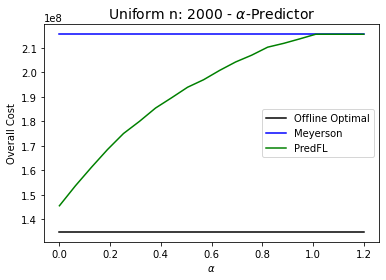

In [120]:
plt.plot(alpha_iters, [uniform_optimal_cost] * msrm_num, 'k', label='Offline Optimal')
plt.plot(alpha_iters, [uniform_meyerson_cost] * msrm_num, 'b', label='Meyerson')
plt.plot(alpha_iters, uniform_alpha, 'g', label='PredFL')
plt.xlabel(r'$\alpha$')
plt.ylabel('Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Predictor'), fontsize=14)

plt.savefig("uniform_alpha_cost")

In [121]:
uniform_alpha_cp = calculate_cp(uniform_optimal_cost, uniform_alpha)

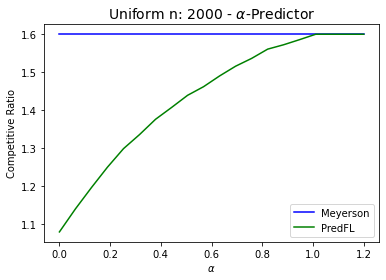

In [122]:
plt.plot(alpha_iters, [uniform_meyerson_cost/uniform_optimal_cost] * msrm_num, 'b', label='Meyerson')
plt.plot(alpha_iters, uniform_alpha_cp, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Predictor'), fontsize=14)

plt.savefig("uniform_alpha_cp")

#### [3.2] Performance over alpha  (alpha_gaussian_predictor)

In [ ]:
alpha_iters = np.linspace(0,1.2,msrm_num)

params = {
    'points' : uniform_wcs, 
    'f' : f_diameter,
    'optimal_solution' : uniform_solution,
    'predictor' : alpha_gaussian_predictor,
    'predictor_params' : alpha_iters,
    'avg_iterations' : uniform_avg_iterations,
}


In [ ]:
%%time
uniform_alpha_gaussian_r = run_experiments(**params)

In [131]:
uniform_alpha_gaussian = simulated_costs(uniform_meyerson_cost, uniform_alpha_gaussian_r)

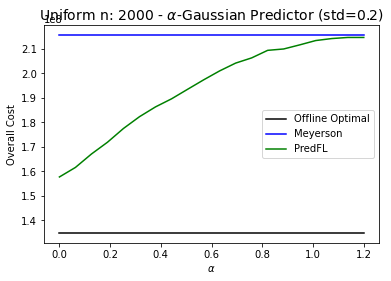

In [133]:
plt.plot(alpha_iters, [uniform_optimal_cost] * msrm_num, 'k', label='Offline Optimal')
plt.plot(alpha_iters, [uniform_meyerson_cost] * msrm_num, 'b', label='Meyerson')
plt.plot(alpha_iters, uniform_alpha_gaussian, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Gaussian Predictor (std=0.2)'), fontsize=14)

plt.savefig("uniform_alpha_gaussian_cost_02")

In [134]:
uniform_alpha_gaussian_cp = calculate_cp(uniform_optimal_cost, uniform_alpha_gaussian)

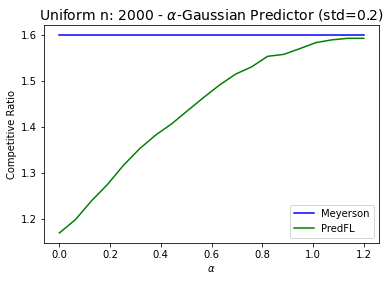

In [135]:
plt.plot(alpha_iters, [uniform_meyerson_cost/uniform_optimal_cost] * msrm_num, 'b', label='Meyerson')
plt.plot(alpha_iters, uniform_alpha_gaussian_cp, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Gaussian Predictor (std=0.2)'), fontsize=14)

plt.savefig("uniform_alpha_gaussian_cp_02")

#### [3.3] Performance over std (alpha_gaussian_predictor) (truncated)

In [194]:
def run_experiments_extra(points, f, optimal_solution, predictor, predictor_params, std, avg_iterations):
    opt_cost, opt_facs, opt_assgn = optimal_solution

    pred_costs = []
    
    for param in predictor_params:
        preds = predictor(opt_assgn, param, std)

        avg_pred = 0
        for _ in range(avg_iterations):
            pred_cost, _, _ = PredFL(points, preds, f)
            avg_pred += pred_cost

            
        avg_pred /= avg_iterations
        pred_costs.append(avg_pred)
    
    return pred_costs

In [294]:
msrm_num = 10

In [196]:
uniform_avg_iterations = 100

In [197]:
alpha_iters = np.linspace(0.5,1.2,msrm_num)

std_iters = [0, 0.2, 0.4]
std_costs_truncated_r = []
for std in std_iters:
    print('! (std: {0})'.format(std),end='')
    
    params = {
        'points' : uniform_wcs, 
        'f' : f_diameter,
        'optimal_solution' : uniform_solution,
        'predictor' : alpha_gaussian_predictor_truncated,
        'predictor_params' : alpha_iters,
        'std' : std,
        'avg_iterations' : uniform_avg_iterations,
    }
    std_costs_truncated_r.append(run_experiments_extra(**params))

! (std: 0.1)! (std: 0.2)! (std: 0.3)! (std: 0.4)

In [201]:
# save_solutions(std_costs_truncated_r, 'std_costs_truncated_r')

In [311]:
std_costs_truncated = []
std_number = len(std_iters)

for i in range(std_number):
    std_costs_truncated.append(simulated_costs(uniform_meyerson_cost, std_costs_truncated_r[i]))

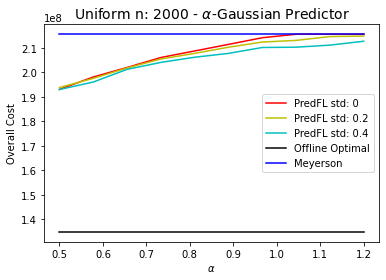

In [327]:
colors = ['r', 'y', 'c', 'm', 'green']
# colors = ['r', 'm', 'green']

for i in range(std_number):
    plt.plot(alpha_iters, std_costs_truncated[i], colors[i], label='PredFL std: {0}'.format(round(std_iters[i],2)))

plt.plot(alpha_iters, [uniform_optimal_cost] * msrm_num, 'k', label='Offline Optimal')
plt.plot(alpha_iters, [uniform_meyerson_cost] * msrm_num, 'b', label='Meyerson')

plt.xlabel(r'$\alpha$')
plt.ylabel('Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Gaussian Predictor'), fontsize=14)

plt.savefig("uniform_std_costs_t")

In [328]:
std_cp_truncated = []

for i in range(std_number):
    std_cp_truncated.append(calculate_cp(uniform_optimal_cost, std_costs_truncated[i]))

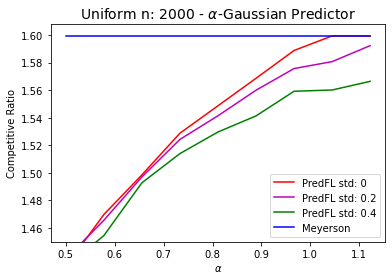

In [330]:
# colors = ['r', 'y', 'c', 'm', 'green']
colors = ['r', 'm', 'green']

# plt.subplots(figsize=(15,3))
for i in range(std_number):
    plt.plot(alpha_iters[:-1], std_cp_truncated[i][:-1], colors[i], label='PredFL std: {0}'.format(round(std_iters[i],2)))

plt.plot(alpha_iters[:-1], [uniform_meyerson_cost / uniform_optimal_cost] * (msrm_num-1), 'b', label='Meyerson')

plt.ylim(bottom=1.450)

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Gaussian Predictor'), fontsize=14)

plt.savefig("uniform_std_cp_t")

#### [3.4] Performance over alpha (random_alpha_predictor)

In [367]:
msrm_num = 20

In [369]:
alpha_iters = np.linspace(0,1.2,msrm_num)

params = {
    'points' : uniform_wcs, 
    'f' : f_diameter,
    'optimal_solution' : uniform_solution,
    'predictor' : random_alpha_predictor,
    'predictor_params' : alpha_iters,
    'avg_iterations' : uniform_avg_iterations,
}


In [370]:
%%time
uniform_random_alpha_r = run_experiments(**params)

CPU times: user 14min 7s, sys: 22.9 s, total: 14min 30s
Wall time: 13min 46s


In [371]:
uniform_random_alpha = simulated_costs(uniform_meyerson_cost, uniform_random_alpha_r)

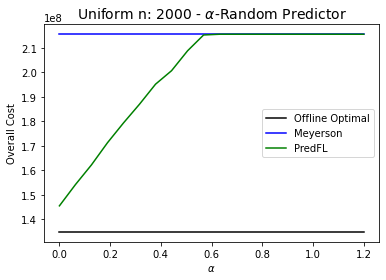

In [372]:
plt.plot(alpha_iters, [uniform_optimal_cost] * msrm_num, 'k', label='Offline Optimal')
plt.plot(alpha_iters, [uniform_meyerson_cost] * msrm_num, 'b', label='Meyerson')
plt.plot(alpha_iters, uniform_random_alpha, 'g', label='PredFL')
plt.xlabel(r'$\alpha$')
plt.ylabel('Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Random Predictor'), fontsize=14)

plt.savefig("uniform_random_alpha_cost")

In [373]:
uniform_random_alpha_cp = calculate_cp(uniform_optimal_cost, uniform_random_alpha)

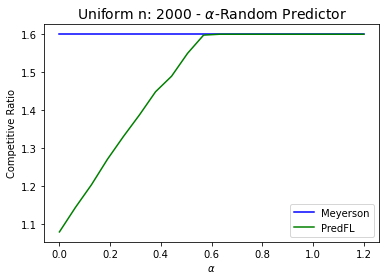

In [374]:
plt.plot(alpha_iters, [uniform_meyerson_cost/uniform_optimal_cost] * msrm_num, 'b', label='Meyerson')
plt.plot(alpha_iters, uniform_random_alpha_cp, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("Uniform n: {0} - {1}".format(n_uniform, r'$\alpha$-Random Predictor'), fontsize=14)

plt.savefig("uniform_random_alpha_cp")